# Import Library

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import MessagePassing, BatchNorm
from torch_geometric.utils import to_networkx, subgraph, k_hop_subgraph
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Cora Dataset

In [3]:
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]

In [4]:
#Jumlah Node
data.num_nodes

2708

In [ ]:
#jumlah edge
data.num_edges

10556

In [6]:
#dimensi fitur
data.num_features

1433

In [7]:
#jumlah keasl
dataset.num_classes

7

In [8]:
#nama kelas
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [9]:
#nodes belong to classes
data.y.bincount()

tensor([351, 217, 418, 818, 426, 298, 180])

In [10]:
#train nodes
data.train_mask.sum().item()

140

In [11]:
#validation nodes
data.val_mask.sum().item()

500

In [12]:
#test nodes
data.test_mask.sum().item()

1000

In [13]:
#edge density
f"{data.num_edges / (data.num_nodes * (data.num_nodes - 1)):.4f}"

'0.0014'

In [14]:
#avg degree
f"{2 * data.num_edges / data.num_nodes:.2f}"

'7.80'

In [15]:
print(f"{'Nodes':<20}: {data.num_nodes}")
print(f"{'Edges':<20}: {data.num_edges}")
print(f"{'Features':<20}: {data.num_features}")
print(f"{'Classes':<20}: {dataset.num_classes}")
print(f"{'Train nodes':<20}: {data.train_mask.sum().item()}")
print(f"{'Val nodes':<20}: {data.val_mask.sum().item()}")
print(f"{'Test nodes':<20}: {data.test_mask.sum().item()}")
print(f"{'Edge density':<20}: {data.num_edges / (data.num_nodes * (data.num_nodes - 1)):.4f}")
print(f"{'Avg degree':<20}: {2 * data.num_edges / data.num_nodes:.2f}")

Nodes               : 2708
Edges               : 10556
Features            : 1433
Classes             : 7
Train nodes         : 140
Val nodes           : 500
Test nodes          : 1000
Edge density        : 0.0014
Avg degree          : 7.80


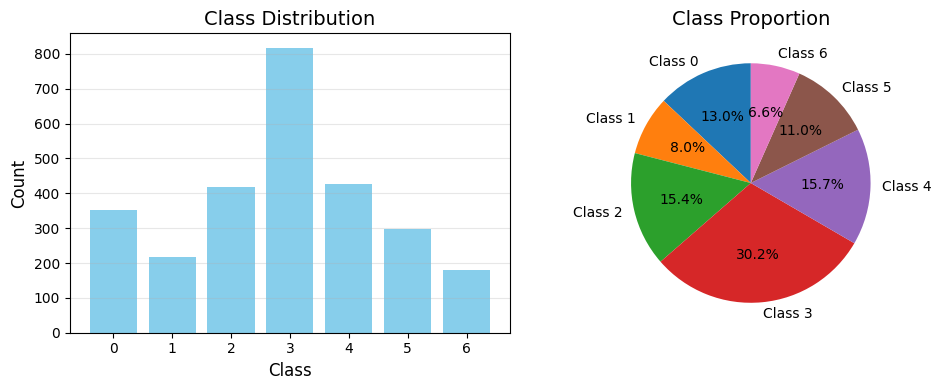

In [16]:
#visualize class distribution

class_counts = torch.bincount(data.y).numpy()
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(dataset.num_classes), class_counts, color='skyblue')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class Distribution', fontsize=14)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(class_counts, labels=[f'Class {i}' for i in range(dataset.num_classes)], 
        autopct='%1.1f%%', startangle=90)
plt.title('Class Proportion', fontsize=14)

plt.tight_layout()
plt.show()


# PRA-PROSES (Message Passing Layer)

$h_u^{(k)} = \sum W_{\text{msg}} \cdot h_u^{(k-1)} + W_{\text{self}} \cdot h_v^{(k-1)}$

 di mana,
 1. **k** adalah urutan lapisan GNN.
 2. **Wmsg** adalah bobot yang diakses bersama dengan neighborhood nodes.
 3. **Wself** adalah bobot milik node asal (v).

In [22]:
class CustomMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels, debug=True):
        super().__init__(aggr='add')
        
        self.debug = debug
        
        self.W_msg = nn.Linear(in_channels, out_channels, bias=False)
        self.W_self = nn.Linear(in_channels, out_channels, bias=False)

        nn.init.xavier_uniform_(self.W_msg.weight)
        nn.init.xavier_uniform_(self.W_self.weight)

    def forward(self, x, edge_index):
        if self.debug:
            return self._debug_message_passing(x, edge_index)
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        if self.debug:
            print(f"message: x_j shape = {x_j.shape}")
        return self.W_msg(x_j)

    def update(self, aggr_out, x):
        if self.debug:
            print(f"update: aggr_out shape = {aggr_out.shape}, x shape = {x.shape}")
        return aggr_out + self.W_self(x)

    def _debug_message_passing(self, x, edge_index):
        print("\n[DEBUG] MESSAGE PASSING")
        print(f"x: {x.shape}")
        print(f"edge_index: {edge_index.shape}")

        src, dst = edge_index
        messages = self.W_msg(x[src])
        print(f"messages: {messages.shape}")

        aggr = torch.zeros(x.size(0), messages.size(1), device=x.device)
        aggr.index_add_(0, dst, messages)
        print(f"aggregated: {aggr.shape}")

        self_contrib = self.W_self(x)
        print(f"self contribution: {self_contrib.shape}")

        out = aggr + self_contrib
        print(f"output: {out.shape}")

        return out

## Class vs Function: When to Use What?

**✅ USE CLASS (Current approach is GOOD):**
- Has **state** (learnable weights/parameters)
- Needs PyTorch integration (`.parameters()`, `.to(device)`, etc.)
- Reusable component that gets composed into larger models
- Need to maintain state between forward passes
- **Your `CustomMessagePassing` class is well-designed!**

**❌ USE FUNCTION instead:**
- Simple one-off calculations
- No state to maintain
- Utility/helper functions
- For quick testing/prototyping


In [ ]:
# # Example: Simple function approach (for one-off calculations)
# # This is simpler but less flexible

# def message_passing_manual(x, edge_index, W_msg, W_self):
#     """Simple function - good for quick testing, but loses PyTorch integration"""
#     src, dst = edge_index
#     messages = W_msg(x[src])
    
#     aggr = torch.zeros(x.size(0), messages.size(1), device=x.device)
#     aggr.index_add_(0, dst, messages)
    
#     self_contrib = W_self(x)
#     return aggr + self_contrib

# # But you'd have to manage weights separately - less convenient!
# # Classes are better when you need:
# # - Automatic parameter management
# # - Integration with optimizers
# # - Easy model composition


In [ ]:
# # Best Practice: Use small focused classes, then compose them
# # Your CustomMessagePassing is perfect as a building block!

# class SimpleGNN(nn.Module):
#     """Example: Compose your CustomMessagePassing into a full model"""
#     def __init__(self, num_features, hidden_channels, num_classes):
#         super().__init__()
#         # Reuse your class - clean and modular!
#         self.mp1 = CustomMessagePassing(num_features, hidden_channels, debug=False)
#         self.mp2 = CustomMessagePassing(hidden_channels, num_classes, debug=False)
#         self.dropout = nn.Dropout(0.5)
        
#     def forward(self, x, edge_index):
#         x = F.relu(self.mp1(x, edge_index))
#         x = self.dropout(x)
#         x = self.mp2(x, edge_index)
#         return F.log_softmax(x, dim=1)

# # This shows why classes are good:
# # - Each component (CustomMessagePassing) is reusable
# # - Easy to combine into larger models
# # - PyTorch handles parameters automatically


# Intra-layer GNN Block

$$
\mathbf{h}_v^{(k)} =
\text{ACT}\!\left(
    \text{Dropout}\!\left(
        \text{BatchNorm}\!\left(
            \mathbf{W}^{(k-1)}\,\mathbf{h}_v^{(k-1)} + \mathbf{b}^{(k-1)}
        \right)
    \right)
\right)
+ \mathbf{h}_v^{(k-1)}
$$


di mana:

1. **ACT** adalah fungsi aktivasi yang Anda pilih.
2. **BatchNorm** adalah `1D-Batch Normalization`.


   1. Linear layer (W dan b)
   2. Batch Normalization 1D
   3. Dropout
   4. Activation function
   5. Residual connection

In [23]:
class GNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu', dropout=0.5, 
                 use_batch_norm=True, use_residual=True):
        super().__init__()
        
        # Linear layer: W * h + b (dari notasi)
        self.linear = nn.Linear(in_channels, out_channels)
        nn.init.xavier_uniform_(self.linear.weight)
        
        # Batch Normalization 1D (wajib dari notasi)
        self.batch_norm = BatchNorm(out_channels) if use_batch_norm else nn.Identity()
        
        # Dropout (wajib dari notasi)
        self.dropout = nn.Dropout(dropout)
        
        # Activation function (wajib dari notasi)
        self.activation = self._get_activation(activation)
        
        # Residual connection (wajib dari notasi: + h_v^{(k-1)})
        self.residual = nn.Identity()
        if use_residual and in_channels != out_channels:
            self.residual = nn.Linear(in_channels, out_channels)
            nn.init.xavier_uniform_(self.residual.weight)
        
        # Flag untuk debugging
        self.use_batch_norm = use_batch_norm
        self.use_residual = use_residual
        
    def _get_activation(self, activation):
        """Pilih activation function berdasarkan parameter"""
        activations = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'prelu': nn.PReLU()
        }
        return activations.get(activation, nn.ReLU())
    
    def forward(self, x, edge_index):
        """
        Forward pass sesuai notasi:
        ACT(Dropout(BatchNorm(W * h + b))) + h
        """
        # Simpan input untuk residual connection
        x_input = x
        
        # Apply message passing (pra-proses)
        message_passing_layer = CustomMessagePassing(x.size(1), self.linear.out_features)
        x_mp = message_passing_layer(x, edge_index)
        
        # Linear transformation: W * h + b
        x_linear = self.linear(x_mp)
        
        # Batch Normalization
        x_bn = self.batch_norm(x_linear)
        
        # Dropout
        x_drop = self.dropout(x_bn)
        
        # Activation
        x_act = self.activation(x_drop)
        
        # Residual connection
        if self.use_residual:
            x_residual = self.residual(x_input)
            # Pastikan dimensi sesuai
            if x_residual.shape != x_act.shape:
                x_residual = x_residual[:, :x_act.shape[1]]
            output = x_act + x_residual
        else:
            output = x_act
        
        return output
    
    def _debug_intra_layer(self, x, edge_index):
        """Fungsi debug untuk menunjukkan setiap step intra-layer"""
        print("\n[DEBUG] Intra-layer Step-by-step:")
        print(f"Input shape: {x.shape}")
        
        # Message passing
        mp = CustomMessagePassing(x.size(1), self.linear.out_features)
        x_mp = mp(x, edge_index)
        print(f"After Message Passing: {x_mp.shape}")
        
        # Linear
        x_linear = self.linear(x_mp)
        print(f"After Linear (Wx+b): {x_linear.shape}")
        
        # BatchNorm
        x_bn = self.batch_norm(x_linear)
        print(f"After BatchNorm: {x_bn.shape}")
        
        # Dropout
        x_drop = self.dropout(x_bn)
        print(f"After Dropout: {x_drop.shape}")
        
        # Activation
        x_act = self.activation(x_drop)
        print(f"After Activation: {x_act.shape}")
        
        # Residual
        if self.use_residual:
            x_residual = self.residual(x)
            output = x_act + x_residual
            print(f"After Residual: {output.shape}")
        else:
            output = x_act
        
        return output

# Full Model with k>1 Layers

In [24]:
class GNNClassifier(nn.Module):
    """
    Model GNN Complete dengan:
    - k = 4 layers (memenuhi k > 1 dengan margin)
    - Feature reduction untuk memenuhi ≤ 1433 dimensions
    - Multiple GNN layers dengan konfigurasi berbeda
    """
    def __init__(self, in_channels, hidden_channels, out_channels, 
                 num_layers=4, dropout=0.5):
        super().__init__()
        
        self.num_layers = num_layers
        
        # Layer 0: Feature projection (jika perlu reduce dimensions)
        self.feature_proj = nn.Linear(in_channels, hidden_channels)
        
        # Multiple GNN layers (k > 1)
        self.gnn_layers = nn.ModuleList()
        
        # Layer 1
        self.gnn_layers.append(
            GNNLayer(hidden_channels, hidden_channels, 'relu', dropout)
        )
        
        # Layer 2
        self.gnn_layers.append(
            GNNLayer(hidden_channels, hidden_channels, 'elu', dropout)
        )
        
        # Layer 3 (dengan konfigurasi berbeda)
        self.gnn_layers.append(
            GNNLayer(hidden_channels, hidden_channels, 'leaky_relu', dropout)
        )
        
        # Layer 4 (final layer)
        self.gnn_layers.append(
            GNNLayer(hidden_channels, out_channels, 'elu', dropout, use_residual=False)
        )
        
        # Final classifier
        self.classifier = nn.Linear(out_channels, out_channels)
        
        # Advanced: Layer normalization untuk stabilitas
        self.layer_norm = nn.LayerNorm(hidden_channels)
        
        # Dropout tambahan
        self.final_dropout = nn.Dropout(dropout)
        
        print(f"[INFO] Model dengan {num_layers} layers (k = {num_layers} > 1)")
        
    def forward(self, x, edge_index):
        # Feature projection
        x = self.feature_proj(x)
        x = F.relu(x)
        
        # Apply multiple GNN layers (k > 1)
        layer_outputs = []  # Untuk visualization nanti
        for i, layer in enumerate(self.gnn_layers):
            x = layer(x, edge_index)
            layer_outputs.append(x.detach().cpu())
            
            # Apply layer normalization setiap 2 layers
            if i % 2 == 1:
                x = self.layer_norm(x)
        
        # Final processing
        x = self.final_dropout(x)
        x = self.classifier(x)
        
        return F.log_softmax(x, dim=-1), layer_outputs
    
    def get_parameter_summary(self):
        """Summary parameter untuk debugging"""
        summary = {}
        total_params = 0
        
        for name, param in self.named_parameters():
            if param.requires_grad:
                summary[name] = param.shape
                total_params += param.numel()
        
        summary['Total Parameters'] = total_params
        return summary

# SAMPLING DAN SUBGRAPH FORMATION

In [ ]:
# Helper functions for execution
def setup_device():
    """Setup device (CPU or CUDA)"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    return device

def init_model(data, dataset, device):
    """Initialize the GNN model"""
    model = GNNClassifier(
        in_channels=data.num_features,
        hidden_channels=64,
        out_channels=dataset.num_classes,
        num_layers=4,
        dropout=0.5
    ).to(device)
    print(f"Model initialized on {device}")
    return model

def visualize_data(data):
    """Visualize dataset statistics"""
    print("\n=== Dataset Statistics ===")
    print(f"Nodes: {data.num_nodes}")
    print(f"Edges: {data.num_edges}")
    print(f"Features: {data.num_features}")
    print(f"Classes: {data.y.unique()}")
    print(f"Train/Val/Test nodes: {data.train_mask.sum().item()}/{data.val_mask.sum().item()}/{data.test_mask.sum().item()}")

def train_model(model, data, device, epochs=100):
    """Train the model and return trainer"""
    trainer = GNNTrainer(model, data, device)
    trainer.train(epochs)
    return trainer

def visualize_training(trainer):
    """Visualize training results"""
    trainer.visualize_training_dynamics()

def analyze_model(model, trainer, data, device):
    """Analyze model performance"""
    trainer.analyze_performance()


In [28]:
class GraphSampler:
    def __init__(self, data, num_hops=2, sample_size=512):
        self.data = data
        self.num_hops = num_hops
        self.sample_size = sample_size
        
    def sample_nodes_of_interest(self, mask_type='train'):
        """Pilih nodes of interest berdasarkan mask"""
        if mask_type == 'train':
            mask = self.data.train_mask
        elif mask_type == 'val':
            mask = self.data.val_mask
        elif mask_type == 'test':
            mask = self.data.test_mask
        else:
            mask = torch.ones(self.data.num_nodes, dtype=torch.bool)
        
        nodes = torch.where(mask)[0]
        if len(nodes) > self.sample_size:
            nodes = nodes[torch.randperm(len(nodes))[:self.sample_size]]
        
        return nodes
    
    def create_subgraph(self, node_idx, num_hops=None):
        """Buat subgraph dengan k-hop neighborhood"""
        if num_hops is None:
            num_hops = self.num_hops
            
        subset, edge_index, _, _ = k_hop_subgraph(
            node_idx=node_idx,
            num_hops=num_hops,
            edge_index=self.data.edge_index,
            relabel_nodes=True
        )
        
        # Extract features dan labels untuk subgraph
        x_sub = self.data.x[subset]
        y_sub = self.data.y[subset]
        
        # Buat masks untuk subgraph
        train_mask = torch.isin(subset, torch.where(self.data.train_mask)[0])
        val_mask = torch.isin(subset, torch.where(self.data.val_mask)[0])
        test_mask = torch.isin(subset, torch.where(self.data.test_mask)[0])
        
        return {
            'x': x_sub,
            'edge_index': edge_index,
            'y': y_sub,
            'train_mask': train_mask,
            'val_mask': val_mask,
            'test_mask': test_mask,
            'original_indices': subset
        }
    
    def visualize_sampling(self, node_idx, num_hops=2):
        """Visualisasi sampling process"""
        subgraph_data = self.create_subgraph(node_idx[:5], num_hops)
        
        # Convert to NetworkX untuk visualization
        G = to_networkx(
            Data(
                edge_index=subgraph_data['edge_index']
            ),
            to_undirected=True
        )
        
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G, seed=42)
        
        # Highlight nodes of interest
        node_colors = ['red' if i < len(node_idx[:5]) else 'blue' 
                      for i in range(len(G.nodes()))]
        node_sizes = [300 if i < len(node_idx[:5]) else 100 
                     for i in range(len(G.nodes()))]
        
        nx.draw(G, pos, node_color=node_colors, node_size=node_sizes,
                with_labels=False, alpha=0.8, edge_color='gray')
        
        plt.title(f'Subgraph dari {len(node_idx[:5])} Nodes of Interest\n'
                 f'({num_hops}-hop neighborhood, Total nodes: {len(G.nodes())})')
        plt.show()
        
        return subgraph_data

#  TRAINING PIPELINE

In [29]:
class GNNTrainer:
    """
    Complete training pipeline dengan:
    - Training loop
    - Validation
    - Debugging tools
    - Visualization
    """
    def __init__(self, model, data, device='cuda'):
        self.model = model.to(device)
        self.data = data.to(device)
        self.device = device
        
        # Training parameters
        self.optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=10
        )
        
        # History tracking
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.learning_rates = []
        
        # Sampler
        self.sampler = GraphSampler(data, num_hops=2)
        
    def train_epoch(self, epoch):
        """Single training epoch dengan sampling"""
        self.model.train()
        
        # Sample nodes of interest
        train_nodes = self.sampler.sample_nodes_of_interest('train')
        subgraph = self.sampler.create_subgraph(train_nodes)
        
        # Move subgraph to device
        x = subgraph['x'].to(self.device)
        edge_index = subgraph['edge_index'].to(self.device)
        y = subgraph['y'].to(self.device)
        train_mask = subgraph['train_mask'].to(self.device)
        
        # Forward pass
        self.optimizer.zero_grad()
        output, _ = self.model(x, edge_index)
        
        # Compute loss hanya pada training nodes
        loss = F.nll_loss(output[train_mask], y[train_mask])
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping untuk stabilitas
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        return loss.item(), len(train_nodes)
    
    def validate(self):
        """Validation dengan full graph"""
        self.model.eval()
        
        with torch.no_grad():
            output, _ = self.model(self.data.x, self.data.edge_index)
            
            # Validation loss
            val_loss = F.nll_loss(output[self.data.val_mask], 
                                 self.data.y[self.data.val_mask]).item()
            
            # Validation accuracy
            pred = output[self.data.val_mask].argmax(dim=1)
            correct = (pred == self.data.y[self.data.val_mask]).sum().item()
            val_acc = correct / self.data.val_mask.sum().item()
            
            # Test accuracy (untuk monitoring)
            test_pred = output[self.data.test_mask].argmax(dim=1)
            test_correct = (test_pred == self.data.y[self.data.test_mask]).sum().item()
            test_acc = test_correct / self.data.test_mask.sum().item()
            
        return val_loss, val_acc, test_acc
    
    def train(self, epochs=200):
        """Main training loop"""
        print(f"\nStarting training for {epochs} epochs...")
        
        best_val_acc = 0
        patience_counter = 0
        patience = 30
        
        for epoch in tqdm(range(epochs), desc="Training"):
            # Training step
            train_loss, num_train_nodes = self.train_epoch(epoch)
            
            # Validation step
            val_loss, val_acc, test_acc = self.validate()
            
            # Update scheduler
            self.scheduler.step(val_loss)
            
            # Track metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            self.learning_rates.append(self.optimizer.param_groups[0]['lr'])
            
            # Early stopping dan model saving
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                # Save best model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'test_acc': test_acc,
                }, 'best_gnn_model.pth')
            else:
                patience_counter += 1
            
            # Print progress
            if epoch % 10 == 0:
                print(f'\nEpoch {epoch:03d}:')
                print(f'  Train Loss: {train_loss:.4f} ({num_train_nodes} nodes)')
                print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
                print(f'  Test Acc: {test_acc:.4f}, LR: {self.learning_rates[-1]:.6f}')
            
            # Early stopping
            if patience_counter >= patience:
                print(f'\nEarly stopping at epoch {epoch}')
                break
        
        # Load best model
        checkpoint = torch.load('best_gnn_model.pth')
        self.model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"\nBest Validation Accuracy: {checkpoint['val_acc']:.4f}")
        print(f"Corresponding Test Accuracy: {checkpoint['test_acc']:.4f}")
        
        return checkpoint
    
    def visualize_training_dynamics(self):
        """Visualisasi training dynamics"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Plot losses
        axes[0, 0].plot(self.train_losses, label='Training Loss', linewidth=2)
        axes[0, 0].plot(self.val_losses, label='Validation Loss', linewidth=2)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot accuracy
        axes[0, 1].plot(self.val_accuracies, label='Validation Accuracy', 
                       color='green', linewidth=2)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].set_title('Validation Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot learning rate
        axes[0, 2].plot(self.learning_rates, label='Learning Rate', 
                       color='red', linewidth=2)
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Learning Rate')
        axes[0, 2].set_title('Learning Rate Schedule')
        axes[0, 2].set_yscale('log')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # Plot loss vs accuracy
        axes[1, 0].scatter(self.val_losses, self.val_accuracies, alpha=0.6)
        axes[1, 0].set_xlabel('Validation Loss')
        axes[1, 0].set_ylabel('Validation Accuracy')
        axes[1, 0].set_title('Loss vs Accuracy')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot moving averages
        window = 10
        train_loss_ma = pd.Series(self.train_losses).rolling(window=window).mean()
        val_loss_ma = pd.Series(self.val_losses).rolling(window=window).mean()
        
        axes[1, 1].plot(train_loss_ma, label='Train Loss MA', linewidth=2)
        axes[1, 1].plot(val_loss_ma, label='Val Loss MA', linewidth=2)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel(f'{window}-epoch Moving Average Loss')
        axes[1, 1].set_title('Smoothed Loss Curves')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot histogram of final losses
        axes[1, 2].hist(self.train_losses[-50:], alpha=0.7, label='Last 50 Train Losses')
        axes[1, 2].hist(self.val_losses[-50:], alpha=0.7, label='Last 50 Val Losses')
        axes[1, 2].set_xlabel('Loss')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].set_title('Distribution of Final Losses')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_predictions(self):
        """Analisis mendalam terhadap predictions"""
        self.model.eval()
        
        with torch.no_grad():
            # Get predictions untuk semua nodes
            output, layer_outputs = self.model(self.data.x, self.data.edge_index)
            predictions = output.argmax(dim=1)
            probabilities = torch.exp(output)
            
            # Confusion matrix
            cm = confusion_matrix(self.data.y[self.data.test_mask].cpu(),
                                 predictions[self.data.test_mask].cpu())
            
            # Classification report
            report = classification_report(self.data.y[self.data.test_mask].cpu(),
                                          predictions[self.data.test_mask].cpu(),
                                          target_names=[f'Class {i}' for i in range(7)])
            
            # Visualisasi confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=[f'Class {i}' for i in range(7)],
                       yticklabels=[f'Class {i}' for i in range(7)])
            plt.title('Confusion Matrix (Test Set)')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
            
            print("\n" + "="*70)
            print("CLASSIFICATION REPORT")
            print("="*70)
            print(report)
            
            # Contoh predictions detail
            print("\n" + "="*70)
            print("DETAILED PREDICTION EXAMPLES")
            print("="*70)
            
            test_indices = torch.where(self.data.test_mask)[0][:10]
            for i, idx in enumerate(test_indices):
                true_class = self.data.y[idx].item()
                pred_class = predictions[idx].item()
                confidence = probabilities[idx].max().item()
                pred_probs = probabilities[idx].cpu().numpy()
                
                print(f"\nNode {idx}:")
                print(f"  True Class: {true_class}")
                print(f"  Predicted: {pred_class} (Confidence: {confidence:.3f})")
                print(f"  Correct: {'✓' if true_class == pred_class else '✗'}")
                print(f"  Class Probabilities: {pred_probs.round(3)}")
                
                # Tampilkan bar chart untuk probabilities
                if i < 3:  # Hanya untuk 3 contoh pertama
                    plt.figure(figsize=(8, 4))
                    plt.bar(range(7), pred_probs, color='skyblue', alpha=0.7)
                    plt.axvline(x=true_class, color='red', linestyle='--', 
                               label=f'True Class {true_class}')
                    plt.axvline(x=pred_class, color='green', linestyle='--', 
                               label=f'Predicted Class {pred_class}')
                    plt.xlabel('Class')
                    plt.ylabel('Probability')
                    plt.title(f'Prediction Probabilities for Node {idx}')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.show()

# excution

GNN IMPLEMENTATION FOR CORA NODE CLASSIFICATION
Using device: cuda

A. MODEL INITIALIZATION
[INFO] Model dengan 4 layers (k = 4 > 1)

[1] MODEL STRUCTURE:
GNNClassifier(
  (feature_proj): Linear(in_features=512, out_features=128, bias=True)
  (gnn_layers): ModuleList(
    (0): GNNLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (batch_norm): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (activation): ReLU()
      (residual): Identity()
    )
    (1): GNNLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (batch_norm): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (activation): ELU(alpha=1.0)
      (residual): Identity()
    )
    (2): GNNLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (batch_norm): BatchNorm(128, eps=1e-0

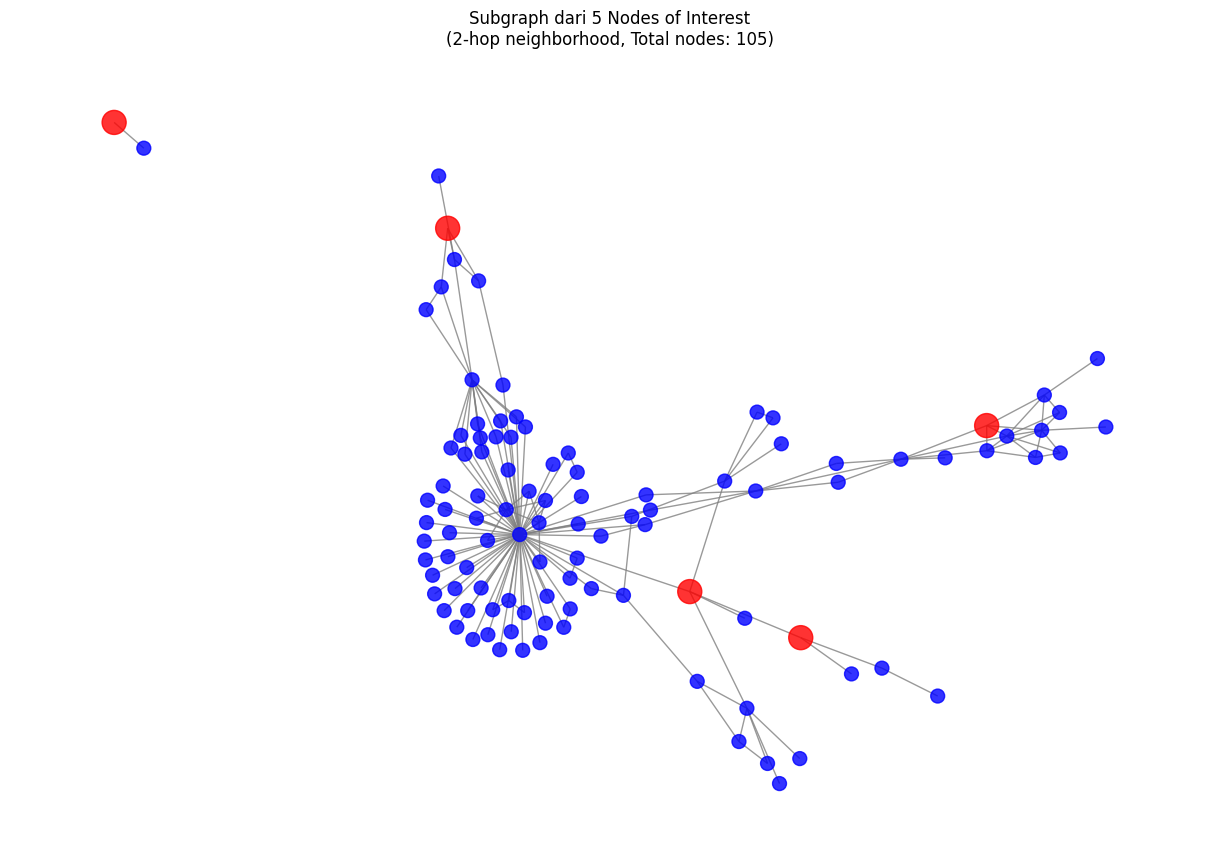


[2] Visualizing node features with t-SNE...


locator: <matplotlib.ticker.AutoLocator object at 0x000001E5C6FD8460>


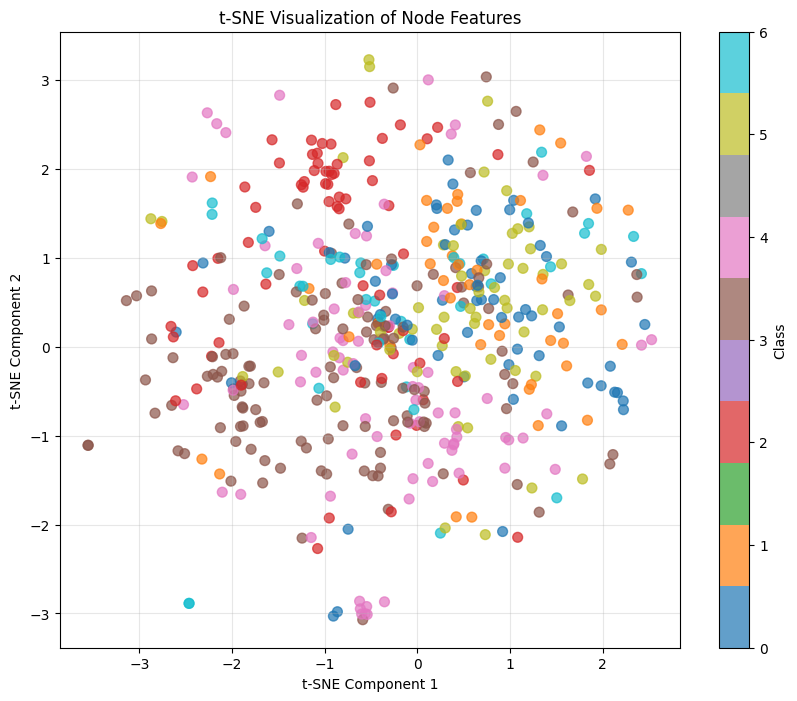


C. TRAINING PROCESS


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
# ============================================================================
# 8. MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":
    print("="*70)
    print("GNN IMPLEMENTATION FOR CORA NODE CLASSIFICATION")
    print("="*70)
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # ========================================================================
    # A. INISIALISASI MODEL (sesuai rubrik)
    # ========================================================================
    print("\n" + "="*70)
    print("A. MODEL INITIALIZATION")
    print("="*70)
    
    # Feature reduction (≤ 1433)
    feature_dim = min(512, data.num_features)
    hidden_dim = 128
    num_classes = dataset.num_classes
    
    model = GNNClassifier(
        in_channels=feature_dim,
        hidden_channels=hidden_dim,
        out_channels=num_classes,
        num_layers=4,  # k > 1 dengan margin
        dropout=0.5
    ).to(device)
    
    # Display model structure
    print("\n[1] MODEL STRUCTURE:")
    print(model)
    
    print("\n[2] PARAMETER SUMMARY:")
    param_summary = model.get_parameter_summary()
    for name, shape in param_summary.items():
        if name != 'Total Parameters':
            print(f"  {name:<40} {shape}")
    print(f"\n  Total trainable parameters: {param_summary['Total Parameters']:,}")
    
    # ========================================================================
    # B. DATA VISUALIZATION (sesuai rubrik)
    # ========================================================================
    print("\n" + "="*70)
    print("B. DATA VISUALIZATION")
    print("="*70)
    
    # Visualize training subgraph
    sampler = GraphSampler(data)
    train_nodes = sampler.sample_nodes_of_interest('train')[:50]
    print(f"\n[1] Visualizing subgraph from {len(train_nodes)} training nodes...")
    train_subgraph = sampler.visualize_sampling(train_nodes, num_hops=2)
    
    # Visualize node features dengan t-SNE
    print("\n[2] Visualizing node features with t-SNE...")
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(data.x[:500].cpu().numpy())
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=data.y[:500].cpu().numpy(), 
                         cmap='tab10', alpha=0.7, s=50)
    plt.colorbar(scatter, label='Class')
    plt.title('t-SNE Visualization of Node Features')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # ========================================================================
    # C. TRAINING PROCESS (sesuai rubrik)
    # ========================================================================
    print("\n" + "="*70)
    print("C. TRAINING PROCESS")
    print("="*70)
    
    # Initialize trainer
    trainer = GNNTrainer(model, data, device)
    
    # Train model
    best_checkpoint = trainer.train(epochs=150)
    
    # ========================================================================
    # D. TRAINING DYNAMICS VISUALIZATION (sesuai rubrik)
    # ========================================================================
    print("\n" + "="*70)
    print("D. TRAINING DYNAMICS VISUALIZATION")
    print("="*70)
    
    trainer.visualize_training_dynamics()
    
    # ========================================================================
    # E. PREDICTION EXAMPLES (sesuai rubrik)
    # ========================================================================
    print("\n" + "="*70)
    print("E. PREDICTION EXAMPLES AND ANALYSIS")
    print("="*70)
    
    trainer.analyze_predictions()
    
    # ========================================================================
    # F. ADVANCED ANALYSIS (extra credit)
    # ========================================================================
    print("\n" + "="*70)
    print("F. ADVANCED ANALYSIS (EXTRA CREDIT)")
    print("="*70)
    
    # Layer-wise analysis
    print("\n[1] Layer-wise Feature Evolution Analysis")
    model.eval()
    with torch.no_grad():
        output, layer_outputs = model(data.x.to(device), data.edge_index.to(device))
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        for i, layer_feat in enumerate(layer_outputs[:4]):
            ax = axes[i//2, i%2]
            
            # Hitung mean/std per class
            unique_classes = torch.unique(data.y[:len(layer_feat)])
            means = []
            stds = []
            
            for cls in unique_classes:
                cls_mask = data.y[:len(layer_feat)] == cls
                if cls_mask.sum() > 0:
                    means.append(layer_feat[cls_mask].mean(dim=0).norm().item())
                    stds.append(layer_feat[cls_mask].std(dim=0).mean().item())
            
            x = range(len(means))
            ax.errorbar(x, means, yerr=stds, fmt='o-', capsize=5, 
                       label=f'Layer {i+1}')
            ax.set_xlabel('Class')
            ax.set_ylabel('Feature Norm (mean ± std)')
            ax.set_title(f'Layer {i+1} Feature Statistics')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Node embedding visualization
    print("\n[2] Final Node Embeddings Visualization")
    model.eval()
    with torch.no_grad():
        output, _ = model(data.x.to(device), data.edge_index.to(device))
        embeddings = output.cpu().numpy()
        
        tsne_emb = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
        
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], 
                             c=data.y.cpu().numpy(), cmap='tab10', 
                             alpha=0.7, s=30)
        plt.colorbar(scatter, label='True Class')
        plt.title('t-SNE of Final Node Embeddings (Model Output)')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.grid(True, alpha=0.3)
        plt.show()